# Imports

In [1]:
import ast
import itertools
import json
from collections import OrderedDict
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss

# Constants

In [2]:
# Control flags for different phases of the workflow
IS_TO_BENCHMARK = False

# File paths
PATH = "../dataset"
DATA_FILENAME = f"{PATH}/data.csv"

sns.set_palette("Set2")

# Data Loading

In [3]:
# Load the dataset from CSV file
df = pd.read_csv(DATA_FILENAME)

# Convert the timestamp column to datetime format and set it as the index
df['Data e Hora'] = pd.to_datetime(df['Data e Hora'])
df = df.set_index('Data e Hora')
df = df.resample('ME').sum()
df.head()

,producao_total,producao_renovavel,hidrica,eolica,solar,ondas,biomassa,producao_nao_renovavel,carvao,gas_natural,termica,producao_por_bombagem,importacao,exportacao
Data e Hora,,,,,,,,,,,,,,
2011-01-31,4892.526012,3423.252563,2276.403022,919.765718,10.304928,0.0,216.778897,1444.418923,182.76521,1137.368657,124.285055,24.854529,265.0814,214.5125
2011-02-28,4511.822790,2422.695050,1424.711670,809.385451,15.417990,0.0,173.179938,2066.896786,595.36520,1362.327677,109.203909,22.230954,132.2835,287.3894
2011-03-31,4455.626875,2617.358004,1508.409231,874.956988,18.236051,0.0,215.755732,1809.700066,277.45060,1412.156919,120.092547,28.568807,294.0840,283.5649
2011-04-30,3439.142913,2110.096542,1176.805883,702.344559,21.839945,0.0,209.106153,1287.812490,89.38100,1094.976514,103.454974,41.233883,541.5129,40.2468
2011-05-31,4181.746980,1656.608468,948.962390,464.240136,25.769034,0.0,217.636912,2490.860302,758.01909,1628.825299,104.015909,34.278212,219.9602,265.0287


In [4]:
# Extract the target columns for renewable and non-renewable energy production
renewables_df = np.log1p(df["producao_renovavel"])
non_renewables_df = np.log1p(df["producao_nao_renovavel"])

# Time series stationarity check

## Auxiliary functions

In [5]:
# Function to perform Augmented Dickey-Fuller Test
def perform_adf_test_diff(data, series_name):
    result = adfuller(data.values.flatten(), regression='c')
    print(f"Augmented Dickey-Fuller Test for {series_name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print(f"Used lags: {result[2]}")
    print(f"Num obs: {result[3]}")
    critical_values = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.3f}")
    
    # H0 hypothesis check
    if result[1] < 0.05:
        print("H0 rejected: The series is stationary.\n")
    else:
        print("Failed to reject H0: The series is not stationary.\n")


def perform_kpss_test(data, series_name):
    """Perform KPSS test and print results."""
    result = kpss(data.values, regression='c')
    print(f"Kwiatkowski-Phillips-Schmidt-Shin Test for {series_name}")
    print(f"KPSS Statistic: {result[0]:.4f}")
    print("Critical Values:")
    critical_values = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
    for key, value in critical_values.items():
        print(f"\t{key}: {value:.3f}")
    
    # H0 hypothesis check
    # Compare the KPSS statistic with the critical value at the 5% significance level
    if result[0] > result[3]['5%']:
        print("H0 rejected: The series is not stationary.\n")
    else:
        print("Failed to reject H0: The series is stationary.\n")

## Renewables

In [6]:
perform_adf_test_diff(renewables_df, "Renewables")
perform_kpss_test(renewables_df, "Renewables")

Augmented Dickey-Fuller Test for Renewables
ADF Statistic: -2.3028
p-value: 0.1711
Used lags: 9
Num obs: 163
	1%: -3.471
	5%: -2.879
	10%: -2.576
Failed to reject H0: The series is not stationary.

Kwiatkowski-Phillips-Schmidt-Shin Test for Renewables
KPSS Statistic: 0.7496
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
H0 rejected: The series is not stationary.



/var/folders/jg/syqy51bd1cvbjp8td8f2myk00000gn/T/ipykernel_11725/3608153830.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data.values, regression='c')


# Non-renewables

In [7]:
perform_adf_test_diff(non_renewables_df, "Non-renewables")
perform_kpss_test(non_renewables_df, "Non-renewables")

Augmented Dickey-Fuller Test for Non-renewables
ADF Statistic: 0.6314
p-value: 0.9884
Used lags: 13
Num obs: 159
	1%: -3.472
	5%: -2.880
	10%: -2.577
Failed to reject H0: The series is not stationary.

Kwiatkowski-Phillips-Schmidt-Shin Test for Non-renewables
KPSS Statistic: 1.0746
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347
H0 rejected: The series is not stationary.



/var/folders/jg/syqy51bd1cvbjp8td8f2myk00000gn/T/ipykernel_11725/3608153830.py:22: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(data.values, regression='c')


Considering this, applying the first difference is a good method to ensure the time-series is stationary even though ADF rejects $H_0$.

# SARIMA model

In [8]:
# Define the split ratios
train_ratio = 0.9

# Calculate the split points in terms of number of samples
train_split = int(df.shape[0] * train_ratio)

# Split the renewable energy production dataset
renewables_df_train = renewables_df[:train_split]
renewables_df_test = renewables_df[train_split:]

# Split the non-renewable energy production dataset
non_renewables_df_train = non_renewables_df[:train_split]
non_renewables_df_test = non_renewables_df[train_split:]

In [9]:
# Define the parameter ranges for grid search
p = q = range(1, 3)  # Non-seasonal parameters
P = Q = range(3, 6)  # Seasonal parameters
d = D = 1  # Fixed differencing orders
m = [12]  # Seasonal period (e.g., yearly data)

# Generate all combinations of parameters
param_combinations = list(itertools.product(p, [d], q))
seasonal_param_combinations = list(itertools.product(P, [D], Q, m))

def sarima_grid_search(param_combinations: list, seasonal_param_combinations: list, timeseries_df: pd.Series, filename: str) -> Tuple:
    total_iterations = len(param_combinations) * len(seasonal_param_combinations)
    completed_iterations = 0

    aic_values = []
    bic_values = []
    hqic_values = []

    # Perform grid search
    for params in param_combinations:
        for seasonal_params in seasonal_param_combinations:
            try:
                # Define and fit the SARIMA model
                model = SARIMAX(timeseries_df,
                                order=params,
                                seasonal_order=seasonal_params,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                fitted_model = model.fit(disp=False, maxiter=5000)

                temp_aic = fitted_model.aic
                temp_bic = fitted_model.bic
                temp_hqic = fitted_model.hqic

                order = str(params)
                seasonal_order = str(seasonal_params)

                aic_values.append([order, seasonal_order, temp_aic])
                bic_values.append([order, seasonal_order, temp_bic])
                hqic_values.append([order, seasonal_order, temp_hqic])

            except Exception as e:
                continue

            # Update progress
            completed_iterations += 1
            print(f"Progress: {completed_iterations}/{total_iterations} ({(completed_iterations / total_iterations) * 100:.2f}%)")


    # Save the results to a JSON file for later use
    results = {
        "AIC": aic_values,
        "BIC": bic_values,
        "HQIC": hqic_values
    }

    with open(filename, 'w') as json_file:
        json.dump(results, json_file, indent=4)
    
    return aic_values, bic_values, hqic_values

## Renewables

### Benchmark

In [10]:
renewables_grid_search_filename = "renewables_grid_search.json"
if IS_TO_BENCHMARK:
    renewables_aic_values, renewables_bic_values, renewables_hqic_values = sarima_grid_search(param_combinations, seasonal_param_combinations, renewables_df_train, renewables_grid_search_filename)
else:
    with open(renewables_grid_search_filename, 'r') as json_file:
        temp_json = json.load(json_file)
    renewables_aic_values = temp_json["AIC"]
    renewables_bic_values = temp_json["BIC"]
    renewables_hqic_values = temp_json["HQIC"]

### Benchmark Results

In [11]:
# Get top 5 models for AIC, BIC, and HQIC
top_5_aic = sorted(renewables_aic_values, key=lambda x: x[-1])[:5]
top_5_bic = sorted(renewables_bic_values, key=lambda x: x[-1])[:5]
top_5_hqic = sorted(renewables_hqic_values, key=lambda x: x[-1])[:5]

renewables_best_order_aic = top_5_aic[0][0]
renewables_best_order_bic = top_5_bic[0][0]
renewables_best_order_hqic = top_5_hqic[0][0]

renewables_best_seasonal_order_aic = top_5_aic[0][1]
renewables_best_seasonal_order_bic = top_5_aic[0][1]
renewables_best_seasonal_order_hqic = top_5_aic[0][1]

best_aic = top_5_aic[0][2]
best_bic = top_5_bic[0][2]
best_hqic = top_5_hqic[0][2]

print("Top 5 models by AIC:")
for i, model in enumerate(top_5_aic, 1):
    print(f"{i}: Order={model[0]}, Seasonal Order={model[1]}, AIC={model[2]:.3f}")

print("\nTop 5 models by BIC:")
for i, model in enumerate(top_5_bic, 1):
    print(f"{i}: Order={model[0]}, Seasonal Order={model[1]}, BIC={model[2]:.3f}")

print("\nTop 5 models by HQIC:")
for i, model in enumerate(top_5_hqic, 1):
    print(f"{i}: Order={model[0]}, Seasonal Order={model[1]}, HQIC={model[2]:.3f}")

print("\n")

print(f"Best SARIMA order by AIC: {renewables_best_order_aic} and seasonal order by AIC: {renewables_best_seasonal_order_aic} with AIC: {best_aic:.3f}")
print(f"Best SARIMA order by BIC: {renewables_best_order_bic} and seasonal order by BIC: {renewables_best_seasonal_order_bic} with BIC: {best_bic:.3f}")
print(f"Best SARIMA order by HQIC: {renewables_best_order_hqic} and seasonal order by HQIC: {renewables_best_seasonal_order_hqic} with HQIC: {best_hqic:.3f}")

Top 5 models by AIC:
1: Order=(1, 1, 2), Seasonal Order=(4, 1, 4, 12), AIC=-33.714
2: Order=(1, 1, 2), Seasonal Order=(3, 1, 4, 12), AIC=-33.315
3: Order=(2, 1, 2), Seasonal Order=(4, 1, 4, 12), AIC=-31.715
4: Order=(2, 1, 2), Seasonal Order=(3, 1, 4, 12), AIC=-31.334
5: Order=(2, 1, 1), Seasonal Order=(4, 1, 4, 12), AIC=-30.171

Top 5 models by BIC:
1: Order=(1, 1, 2), Seasonal Order=(3, 1, 4, 12), BIC=-5.695
2: Order=(1, 1, 2), Seasonal Order=(4, 1, 4, 12), BIC=-3.584
3: Order=(1, 1, 1), Seasonal Order=(4, 1, 4, 12), BIC=-2.426
4: Order=(1, 1, 2), Seasonal Order=(3, 1, 5, 12), BIC=-1.702
5: Order=(2, 1, 2), Seasonal Order=(3, 1, 4, 12), BIC=-1.204

Top 5 models by HQIC:
1: Order=(1, 1, 2), Seasonal Order=(3, 1, 4, 12), HQIC=-22.172
2: Order=(1, 1, 2), Seasonal Order=(4, 1, 4, 12), HQIC=-21.558
3: Order=(2, 1, 2), Seasonal Order=(3, 1, 4, 12), HQIC=-19.179
4: Order=(1, 1, 1), Seasonal Order=(4, 1, 4, 12), HQIC=-18.970
5: Order=(1, 1, 2), Seasonal Order=(3, 1, 5, 12), HQIC=-18.744


Be

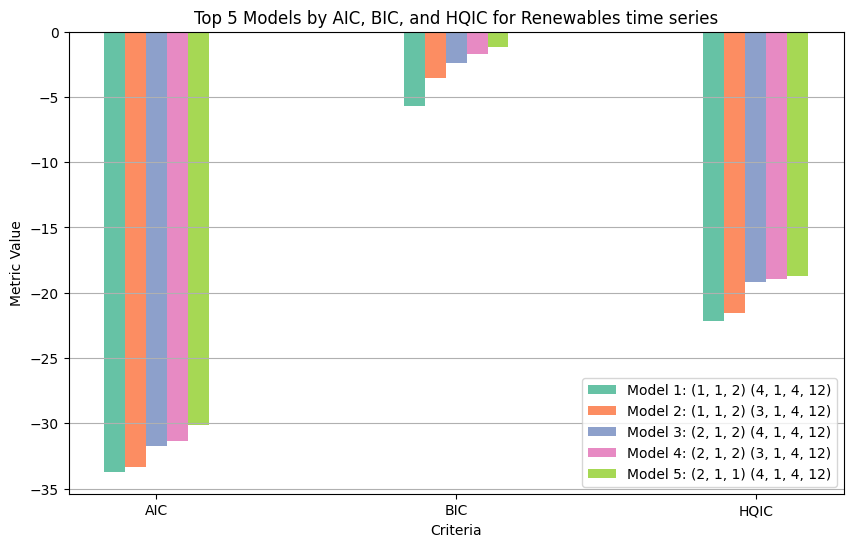

In [12]:
# Extract values for plotting
metrics = ['AIC', 'BIC', 'HQIC']
top_5_values = [top_5_aic, top_5_bic, top_5_hqic]

# Prepare data for the bar chart
x_labels = metrics
bar_width = 0.07
x = np.arange(len(x_labels))

# Plot the bar chart
plt.figure(figsize=(10, 6))
for i in range(5):
    values = [top_5_values[j][i][2] for j in range(len(metrics))]
    plt.bar(x + i * bar_width, values, width=bar_width, label=f"Model {i+1}: {top_5_values[0][i][0]} {top_5_values[0][i][1]}")

# Add labels and title
plt.xticks(x + (2 * bar_width), x_labels)
plt.xlabel("Criteria")
plt.ylabel("Metric Value")
plt.title("Top 5 Models by AIC, BIC, and HQIC for Renewables time series")
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

## Non-renewables

### Benchmark

In [13]:
non_renewables_grid_search_filename = "non_renewables_grid_search.json"
if IS_TO_BENCHMARK:
    non_renewables_aic_values, non_renewables_bic_values, non_renewables_hqic_values = sarima_grid_search(param_combinations, seasonal_param_combinations, non_renewables_df_train, non_renewables_grid_search_filename)
else:
    with open(non_renewables_grid_search_filename, 'r') as json_file:
        temp_json = json.load(json_file)
    non_renewables_aic_values = temp_json["AIC"]
    non_renewables_bic_values = temp_json["BIC"]
    non_renewables_hqic_values = temp_json["HQIC"]

### Benchmark Results

In [14]:
# Get top 5 models for AIC, BIC, and HQIC
top_5_aic = sorted(non_renewables_aic_values, key=lambda x: x[-1])[:5]
top_5_bic = sorted(non_renewables_bic_values, key=lambda x: x[-1])[:5]
top_5_hqic = sorted(non_renewables_hqic_values, key=lambda x: x[-1])[:5]

non_renewables_best_order_aic = top_5_aic[0][0]
non_renewables_best_order_bic = top_5_bic[0][0]
non_renewables_best_order_hqic = top_5_hqic[0][0]

non_renewables_best_seasonal_order_aic = top_5_aic[0][1]
non_renewables_best_seasonal_order_bic = top_5_aic[0][1]
non_renewables_best_seasonal_order_hqic = top_5_aic[0][1]

best_aic = top_5_aic[0][2]
best_bic = top_5_bic[0][2]
best_hqic = top_5_hqic[0][2]

print("Top 5 models by AIC:")
for i, model in enumerate(top_5_aic, 1):
    print(f"{i}: Order={model[0]}, Seasonal Order={model[1]}, AIC={model[2]:.3f}")

print("\nTop 5 models by BIC:")
for i, model in enumerate(top_5_bic, 1):
    print(f"{i}: Order={model[0]}, Seasonal Order={model[1]}, BIC={model[2]:.3f}")

print("\nTop 5 models by HQIC:")
for i, model in enumerate(top_5_hqic, 1):
    print(f"{i}: Order={model[0]}, Seasonal Order={model[1]}, HQIC={model[2]:.3f}")

print("\n")

print(f"Best SARIMA order by AIC: {non_renewables_best_order_aic} and seasonal order by AIC: {non_renewables_best_seasonal_order_aic} with AIC: {best_aic:.3f}")
print(f"Best SARIMA order by BIC: {non_renewables_best_order_bic} and seasonal order by BIC: {non_renewables_best_seasonal_order_bic} with BIC: {best_bic:.3f}")
print(f"Best SARIMA order by HQIC: {non_renewables_best_order_hqic} and seasonal order by HQIC: {non_renewables_best_seasonal_order_hqic} with HQIC: {best_hqic:.3f}")

Top 5 models by AIC:
1: Order=(1, 1, 1), Seasonal Order=(5, 1, 4, 12), AIC=16.043
2: Order=(1, 1, 1), Seasonal Order=(4, 1, 4, 12), AIC=16.468
3: Order=(1, 1, 1), Seasonal Order=(4, 1, 5, 12), AIC=17.674
4: Order=(2, 1, 1), Seasonal Order=(4, 1, 4, 12), AIC=17.748
5: Order=(1, 1, 1), Seasonal Order=(3, 1, 4, 12), AIC=17.935

Top 5 models by BIC:
1: Order=(1, 1, 1), Seasonal Order=(3, 1, 4, 12), BIC=43.153
2: Order=(1, 1, 1), Seasonal Order=(4, 1, 4, 12), BIC=44.207
3: Order=(1, 1, 1), Seasonal Order=(5, 1, 4, 12), BIC=44.776
4: Order=(1, 1, 1), Seasonal Order=(4, 1, 5, 12), BIC=46.259
5: Order=(1, 1, 2), Seasonal Order=(3, 1, 4, 12), BIC=46.278

Top 5 models by HQIC:
1: Order=(1, 1, 1), Seasonal Order=(5, 1, 4, 12), HQIC=27.571
2: Order=(1, 1, 1), Seasonal Order=(4, 1, 4, 12), HQIC=27.663
3: Order=(1, 1, 1), Seasonal Order=(3, 1, 4, 12), HQIC=28.114
4: Order=(1, 1, 1), Seasonal Order=(4, 1, 5, 12), HQIC=29.135
5: Order=(1, 1, 2), Seasonal Order=(3, 1, 4, 12), HQIC=29.802


Best SARIMA 

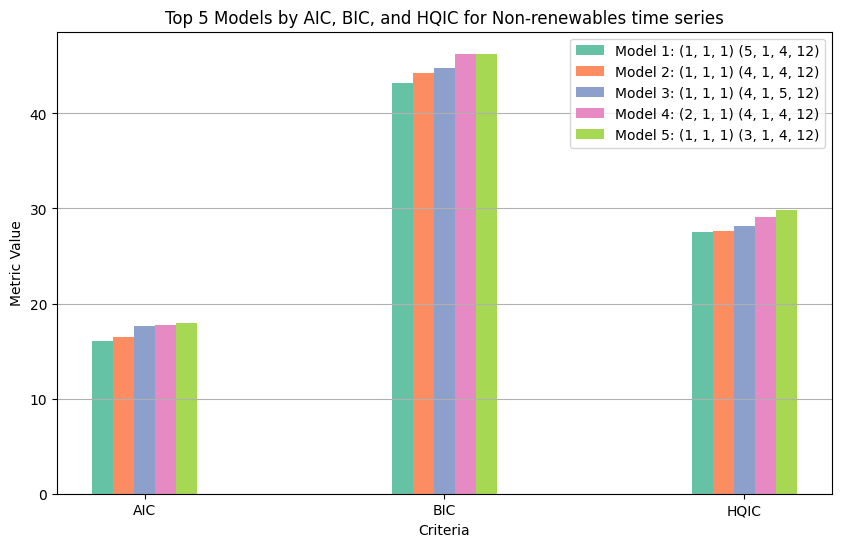

In [15]:
# Extract values for plotting
metrics = ['AIC', 'BIC', 'HQIC']
top_5_values = [top_5_aic, top_5_bic, top_5_hqic]

# Prepare data for the bar chart
x_labels = metrics
bar_width = 0.07
x = np.arange(len(x_labels))

# Plot the bar chart
plt.figure(figsize=(10, 6))
for i in range(5):
    values = [top_5_values[j][i][2] for j in range(len(metrics))]
    plt.bar(x + i * bar_width, values, width=bar_width, label=f"Model {i+1}: {top_5_values[0][i][0]} {top_5_values[0][i][1]}")

# Add labels and title
plt.xticks(x + (2 * bar_width), x_labels)
plt.xlabel("Criteria")
plt.ylabel("Metric Value")
plt.title("Top 5 Models by AIC, BIC, and HQIC for Non-renewables time series")
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

# Best Model Forecasting

## Renewables

In [16]:
best_renewables_order = ast.literal_eval(renewables_best_order_hqic)
best_renewables_seasonal_order = ast.literal_eval(renewables_best_seasonal_order_hqic)

# Create and fit the SARIMAX model
model = SARIMAX(renewables_df_train,
                order=best_renewables_order,
                seasonal_order=best_renewables_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
renewables_fitted_model = model.fit(disp=False)

# Forecast
renewables_forecast = renewables_fitted_model.forecast(steps=len(renewables_df_test))

/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


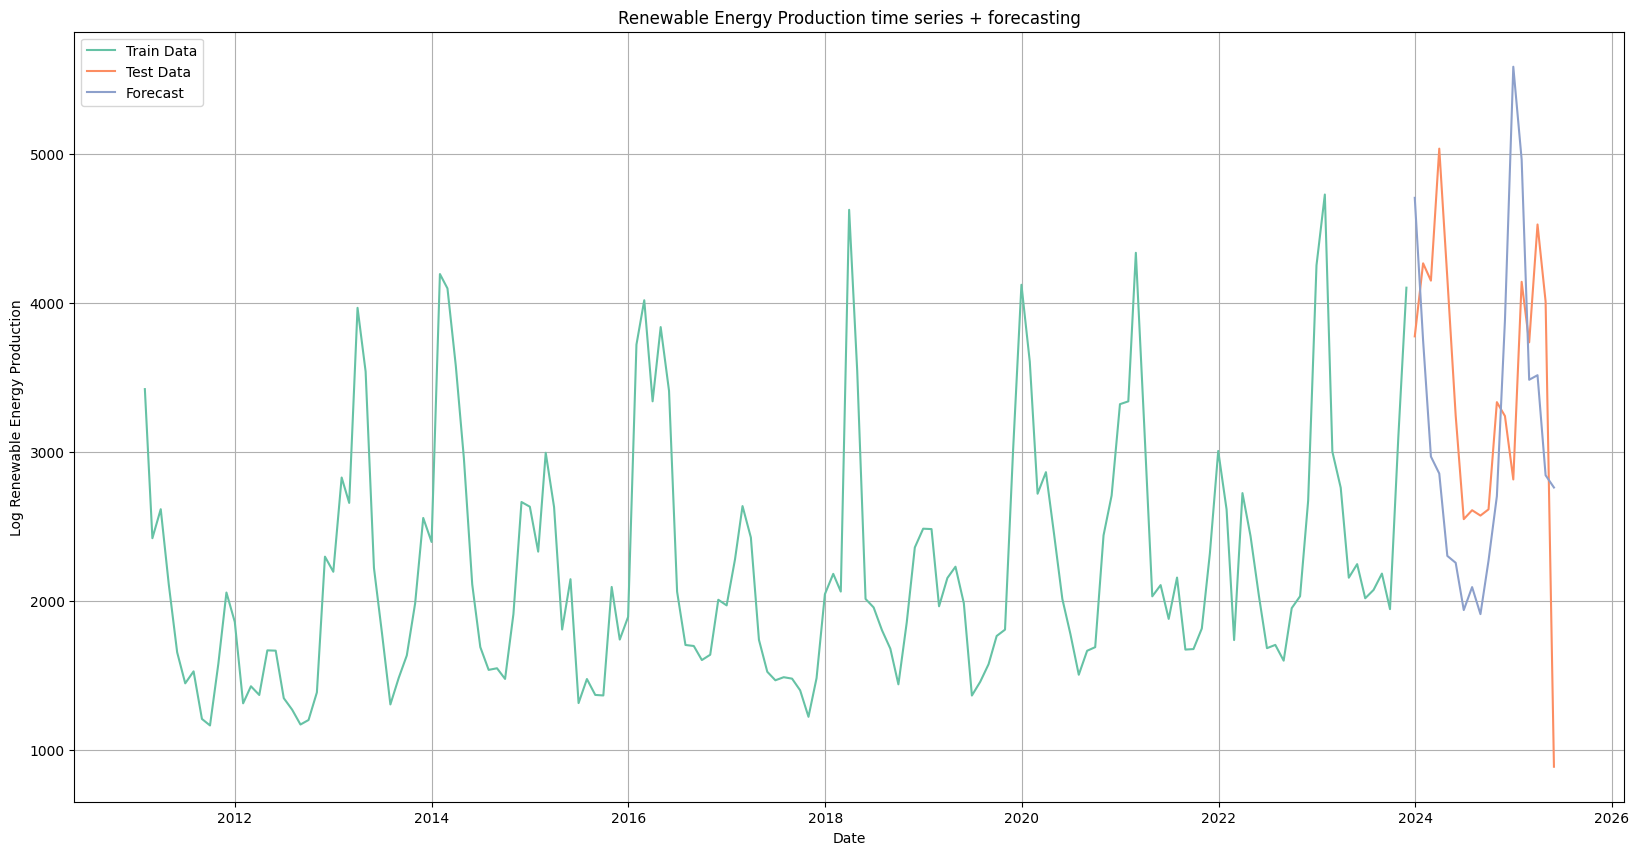

Mean Absolute Error Percentage (MAPE): 4.37%
R-squared: 0.0000


In [17]:
# Plot the results
plt.figure(figsize=(20, 10))

# Plot train data
plt.plot(renewables_df_train.index, np.expm1(renewables_df_train), label='Train Data')
plt.plot(renewables_df_test.index, np.expm1(renewables_df_test), label='Test Data')
plt.plot(renewables_df_test.index, np.expm1(renewables_forecast), label='Forecast')

# Add title and labels
plt.title('Renewable Energy Production time series + forecasting')
plt.xlabel('Date')
plt.ylabel('Log Renewable Energy Production')
plt.legend()
plt.grid()

# Show the plot
plt.show()


# Calculate Mean Absolute Error Percentage (MAPE)
mape = np.mean(np.abs((renewables_df_test.values.flatten() - renewables_forecast.values) / renewables_df_test.values.flatten())) * 100
print(f"Mean Absolute Error Percentage (MAPE): {mape:.2f}%")

# Calculate R-squared
r_squared = r2_score(renewables_df_test.values.flatten(), renewables_forecast.values)
print(f"R-squared: {max(r_squared, 0):.4f}")

## Non-renewables

In [18]:
best_non_renewables_order = ast.literal_eval(non_renewables_best_order_hqic)
best_non_renewables_seasonal_order = ast.literal_eval(non_renewables_best_seasonal_order_hqic)

# Create and fit the SARIMAX model
model = SARIMAX(non_renewables_df_train,
                order=best_non_renewables_order,
                seasonal_order=best_non_renewables_seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False)
non_renewables_fitted_model = model.fit(disp=False)

# Forecast
non_renewables_forecast = non_renewables_fitted_model.forecast(steps=len(renewables_df_test))

/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/xoutoz/workspace/master/ASTP/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


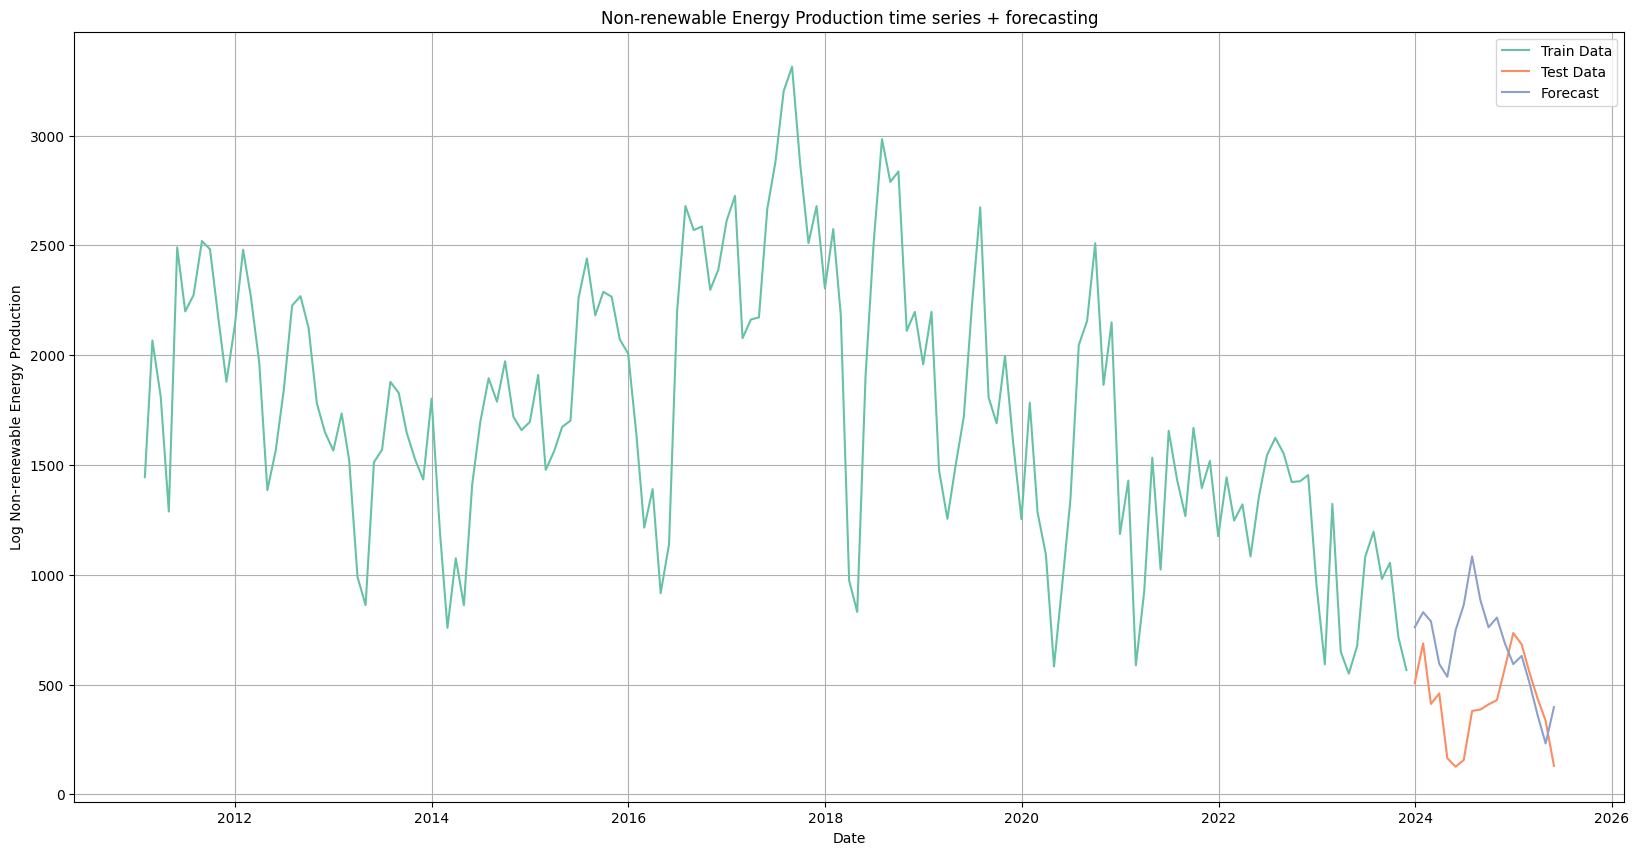

Mean Absolute Error Percentage (MAPE): 11.71%
R-squared: 0.0000


In [19]:
# Plot the results
plt.figure(figsize=(20, 10))

# Plot train data
plt.plot(non_renewables_df_train.index, np.expm1(non_renewables_df_train), label='Train Data')
plt.plot(non_renewables_df_test.index, np.expm1(non_renewables_df_test), label='Test Data')
plt.plot(non_renewables_df_test.index, np.expm1(non_renewables_forecast), label='Forecast')

# Add title and labels
plt.title('Non-renewable Energy Production time series + forecasting')
plt.xlabel('Date')
plt.ylabel('Log Non-renewable Energy Production')
plt.legend()
plt.grid()

# Show the plot
plt.show()


# Calculate Mean Absolute Error Percentage (MAPE)
mape = np.mean(np.abs((non_renewables_df_test.values.flatten() - non_renewables_forecast.values) / non_renewables_df_test.values.flatten())) * 100
print(f"Mean Absolute Error Percentage (MAPE): {mape:.2f}%")

# Calculate R-squared
r_squared = r2_score(non_renewables_df_test.values.flatten(), non_renewables_forecast.values)
print(f"R-squared: {max(r_squared, 0):.4f}")